In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import load_molecules, load_mixtures, load_train, load_validation

## Self-supervised tree-embeddings
This idea uses a pretext task to generate tree embeddings ...

In [2]:
mixtures = utils.load_mixtures()
test_mixtures = utils.load_test_mixtures()

In [3]:
stacked_mixtures = mixtures.stack()
stacked_mixtures = pd.concat([stacked_mixtures, test_mixtures.stack()])  # Include test mixtures
stacked_mixtures = stacked_mixtures[stacked_mixtures != 0]

# TODO: The original molecular features has more molecules missing. Why?
# molecule_features = pd.read_csv("../data/Morgan_Fingerprint.csv", index_col=0)
molecule_features = pd.read_csv("../data/Morgan_Fingerprint_radius2_fpSize2048.csv", index_col=0)
# molecule_features = molecules.filter(like="MORG")

# FIXME: Get missing fingerprints
print("Missing descriptors:", *(set(stacked_mixtures.unique()) - set(molecule_features.index)))
stacked_mixtures = stacked_mixtures[stacked_mixtures.isin(molecule_features.index)]

# FIXME: Get missing values
print(f"Values missing: {molecule_features.isna().mean().mean():.2%}")
# Imputing currently makes it better, but RF can handle NaNs.
molecule_features = molecule_features.fillna(0)

mixture_features = (
    stacked_mixtures.groupby(level=0) # Group by mixtures
    .apply(lambda x: molecule_features.loc[x.tolist()].mean(0))  # Average molecular features (Skips NaN by default)
    .unstack(1)  # One molecular feature per column
)
mixture_features

Missing descriptors: 11002307
Values missing: 0.00%


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
Bushdid/001,0.000000,0.178571,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.0
Bushdid/002,0.035714,0.214286,0.035714,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/003,0.000000,0.300000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/004,0.100000,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/005,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test/88,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/89,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/90,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/91,0.000000,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
display(stacked_mixtures)
mixture_binary_composition = pd.crosstab(
    stacked_mixtures.index.get_level_values(0),
    stacked_mixtures,
)
display(mixture_binary_composition)

Snitz 1/001  CID       6501
             CID.1      264
             CID.2     2879
             CID.3     7685
             CID.4     7731
                      ...  
test/92      CID.5      957
             CID.6    10430
             CID.7    12367
             CID.8     7344
             CID.9     9609
Length: 14439, dtype: int64

col_0,176,177,180,240,261,263,264,307,323,326,...,638011,5281168,5281515,5283349,5284503,5318042,5373603,6259976,19789253,25137858
row_0,,,,,,,,,,,,,,,,,,,,,
Bushdid/001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/002,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bushdid/003,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/004,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test/88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test/89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test/90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.ensemble import RandomForestRegressor
from tree_embedder import ForestEmbedder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

pretext_y = mixture_features

# Mixtures are represented by the a binary vector indicating the presence of
# each known molecule.
pretext_X = mixture_binary_composition

# pretext_X = pd.DataFrame(
#     PCA(n_components=1.0).fit_transform(mixture_binary_composition),
#     index=mixture_binary_composition.index,
# )
# R2 = 0.304 +- 0.069, RMSE = 0.129 +- 0.013, Pearson = 0.584 +- 0.076

# Mixtures are represented by the average similarities between the molecules
# in the mixture and each of the known molecules.
# molecule_similarity = pairwise_distances(molecule_features.loc[mixture_binary_composition.columns], metric="cosine")
# pretext_X = (mixture_binary_composition @ molecule_similarity) / mixture_binary_composition.sum(axis=1).values[:, None]
# R2 = 0.298 +- 0.126, RMSE = 0.128 +- 0.011, Pearson = 0.567 +- 0.126
# 
# plt.title("Molecule similarity distribution")
# pretext_X.stack().hist(bins=100)

# TODO: use chi2 to concentrate on most important nodes that could be thrown away by RF feature sampling
pretext_rf = ForestEmbedder(
    # RandomForestRegressor(max_features="sqrt", random_state=42, n_jobs=10, verbose=50),
    #   R2 = 0.350 +- 0.132, RMSE = 0.124 +- 0.017, Pearson = 0.612 +- 0.120
    # RandomForestRegressor(n_estimators=1000, max_features="log2", random_state=42, n_jobs=10, verbose=50),  # not much difference
    RandomForestRegressor(max_features="log2", random_state=42, n_jobs=10, verbose=50), # Best
    #   R2 = 0.361 +- 0.120, RMSE = 0.123 +- 0.015, Pearson = 0.624 +- 0.107
    # RandomForestRegressor(max_features=1, random_state=42, n_jobs=10, verbose=50),
    #   R2 = 0.344 +- 0.101, RMSE = 0.125 +- 0.014, Pearson = 0.602 +- 0.097
    # RandomForestRegressor(max_features=0.5, random_state=42, n_jobs=10, verbose=50),  # Worst
)
display(pretext_X)

col_0,176,177,180,240,261,263,264,307,323,326,...,638011,5281168,5281515,5283349,5284503,5318042,5373603,6259976,19789253,25137858
row_0,,,,,,,,,,,,,,,,,,,,,
Bushdid/001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/002,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bushdid/003,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/004,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bushdid/005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test/88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test/89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test/90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
pretext_rf.fit(pretext_X, pretext_y)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
building tree 12 of 100
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.0s
building tree 13 of 100
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.0s
building tree 14 of 100
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.0s
building tree 15 of 100
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
building tree 16 of 100
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.0s
building tree 17 of 100
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.0s
building tree 18 of 100
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s

ForestEmbedder(estimator=RandomForestRegressor(max_features='log2', n_jobs=10,
                                               random_state=42, verbose=50))

In [7]:
pretext_y

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
Bushdid/001,0.000000,0.178571,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.0
Bushdid/002,0.035714,0.214286,0.035714,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/003,0.000000,0.300000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/004,0.100000,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Bushdid/005,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test/88,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/89,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/90,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
test/91,0.000000,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [8]:
embeddings = pretext_rf.transform(pretext_X)
embeddings = sparse.hstack([embeddings, pretext_y], format="csr")
embeddings = sparse.hstack([embeddings, pretext_y.index.str.startswith("Bushdid").astype(int)[:, None]], format="csr")
embeddings

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1442773 stored elements and shape (795, 100841)>

In [9]:
from scipy import sparse

df_train = load_train()  # TODO: try differences

def get_mixture_pair_embedding(mixture1, mixture2):
    # Concatenation leads to similar results, but double the number of features.
    # It is also not symmetric, so we would need to consider both (mixture1,
    # mixture2) and (mixture2, mixture1), for example.
    #
    # sparse.hstack([
    #     embeddings[pretext_X.index.get_loc(x["mixture1"])],
    #     embeddings[pretext_X.index.get_loc(x["mixture2"])],
    # ])

    # Absolute difference is symmetric and has half the number of features.
    # np.abs(
    #     embeddings[pretext_X.index.get_loc(x["mixture1"])]
    #     - embeddings[pretext_X.index.get_loc(x["mixture2"])]
    # )
    return np.abs(
        embeddings[pretext_X.index.get_loc(mixture1)]
        - embeddings[pretext_X.index.get_loc(mixture2)]
    )

# Build the training set by taking the absolute difference between the mixture
# embeddings.
X_train = sparse.vstack([  # TODO: use df.apply
    get_mixture_pair_embedding(x["mixture1"], x["mixture2"])
    for _, x in df_train.iterrows()
])
y_train = df_train["distance"]

display(embeddings[0])
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1665 stored elements and shape (1, 100841)>

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1059955 stored elements and shape (500, 100841)>

In [10]:
# rf_final = RandomForestRegressor(verbose=50, random_state=42, n_jobs=1)
##  rf_final = RandomForestRegressor(n_estimators=1000, max_features="sqrt", verbose=50, random_state=42, n_jobs=1)
# rf_final = RandomForestRegressor(max_features="sqrt", verbose=50, random_state=42, n_jobs=1)
#   R2 = 0.362 +- 0.128, RMSE = 0.123 +- 0.016, Pearson = 0.631 +- 0.124
rf_final = RandomForestRegressor(max_features=0.5, verbose=50, random_state=42, n_jobs=1)
#   R2 = 0.368 +- 0.104, RMSE = 0.122 +- 0.014, Pearson = 0.628 +- 0.093

# rf_final.fit(X_train, y_train)
# pred = rf_final.predict(X_train)

In [41]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import warnings

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "R2": "r2",
    "RMSE": "neg_root_mean_squared_error", 
    "Pearson": make_scorer(lambda y, y_pred: pearsonr(y, y_pred)[0]),
}

print(f"{rf_final}: ", end="")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = cross_validate(
        rf_final,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=cv.n_splits,
        verbose=50,
    )

scores["test_RMSE"] = -scores["test_RMSE"]
for i in scores:
    if "test" in i:
        print(f"{i[5:]} ={np.mean(scores[i]):6.3f} +- {np.std(scores[i]):.3f}", end=", ")
print()

RandomForestRegressor(max_features='sqrt', n_estimators=1000, n_jobs=1,
                      random_state=42, verbose=50): [Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

In [72]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(rf_final, X_train, y_train, cv=cv, n_jobs=cv.n_splits)


<Axes: ylabel='distance'>

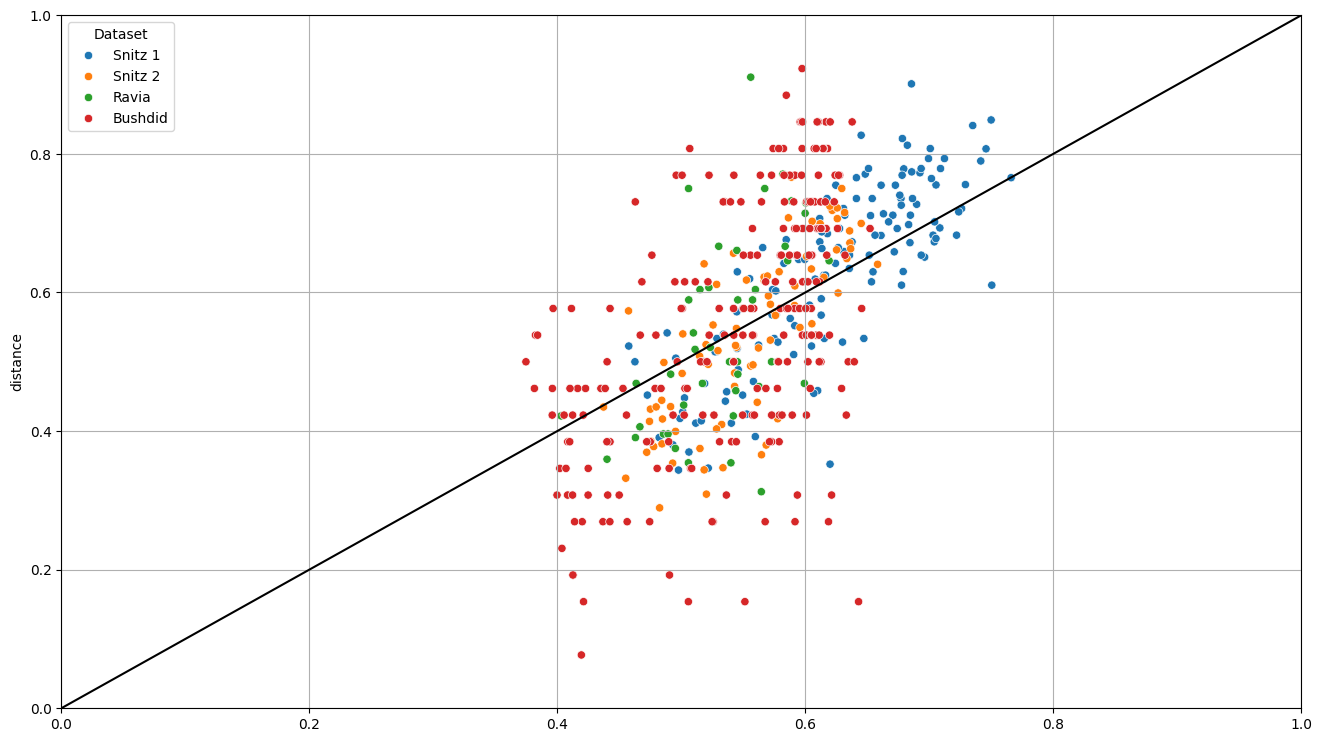

In [73]:

plt.figure(figsize=(16, 9))
plt.grid()
plt.axline((0.5, 0.5), slope=1, color="black")
plt.xlim(0, 1)
plt.ylim(0, 1)
sns.scatterplot(x=y_pred, y=y_train, hue=df_train["Dataset"])

In [11]:
df_train.Dataset.value_counts()

Dataset
Bushdid    234
Snitz 1    140
Snitz 2     81
Ravia       45
Name: count, dtype: Int64

Final fit with all the training data.

In [11]:
rf_final.fit(X_train, y_train)

building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.5s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.3s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.1s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.9s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    4.8s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    5.7s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    6.5s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    7.3s
building tree 10 of 100
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    8.1s
building tree 11 of 100
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    8.9s
building tree 12 of 100
[Parallel(n_jobs=1)]: Done  12 tasks      | elapse

RandomForestRegressor(max_features=0.5, n_jobs=1, random_state=42, verbose=50)

Making the predictions for submission.

In [12]:
df_leaderboard = pd.read_csv("../data/Leaderboard_set_Submission_form.csv")
df_test = pd.read_csv("../data/Test_set_Submission_form.csv")

X_leaderboard = sparse.vstack([
    get_mixture_pair_embedding(f"{x.Dataset}/{x.Mixture_1:03d}", f"{x.Dataset}/{x.Mixture_2:03d}")  # HACK
    for _, x in df_leaderboard.iterrows()
])
leaderboard_submission = df_leaderboard.assign(
    Predicted_Experimental_Values=rf_final.predict(X_leaderboard)
)

X_test = sparse.vstack([
    get_mixture_pair_embedding(f"test/{x.Mixture_1:02d}", f"test/{x.Mixture_2:02d}")  # HACK
    for _, x in df_test.iterrows()
])
test_submission = df_test.assign(
    Predicted_Experimental_Values=rf_final.predict(X_test)
)

dir_submission = Path("../pred/tree_embeddings_morgan_v7/")
dir_submission.mkdir(exist_ok=True, parents=True)
leaderboard_submission.to_csv(dir_submission / "Leaderboard_set_Submission_form.csv", index=False)
test_submission.to_csv(dir_submission / "Test_set_Submission_form.csv", index=False)

# v1:
# R2: 0.40523392351000487
# RMSE: 0.12469965315055702
# Pearson: 0.6735127308141674

# v2 (1000 trees):
# R2: 0.40265782183939736
# RMSE: 0.1249694162593873
# Pearson: 0.674191269703507

# v3 (1000 trees for final and embeddings):
# R2: 0.4042566729680308
# RMSE: 0.12480205709710104
# Pearson: 0.6666885832834468

# v4 (v3 + adding test mixtures)
# R2: 0.3873274728800816
# RMSE: 0.12656288146122543
# Pearson: 0.6547725886197528

# v5 (1000 trees and mixture features)
# R2: 0.4160131482575108
# RMSE: 0.12356449119543043
# Pearson: 0.6801061499394034

# v6 (v5 + binary indicator true if Bushdid)
# R2: 0.4202651692990008
# RMSE: 0.12311383149940601
# Pearson: 0.6833641901924367

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [13]:
y_targets = pd.read_csv("../data/leaderboard_targets.csv", index_col=[0, 1, 2])
# y_targets = y_targets.loc[leaderboard_submission.set_index(["Dataset", "Mixture_1", "Mixture_2"]).index].reset_index()
# y_targets.to_csv("../data/leaderboard_targets.csv", index=False)

In [70]:
display(leaderboard_submission.Predicted_Experimental_Values.values)
display(y_targets.Experimental_value.values)

array([0.55363964, 0.60132063, 0.71562241, 0.64712221, 0.63107552,
       0.69702702, 0.52184663, 0.60850675, 0.6870171 , 0.44181375,
       0.51092729, 0.63238079, 0.61441307, 0.41456249, 0.58011063,
       0.58402064, 0.46565756, 0.47061352, 0.58325833, 0.55100224,
       0.57955567, 0.56902356, 0.46539969, 0.44298595, 0.39693957,
       0.50317326, 0.61535494, 0.51690923, 0.60861113, 0.56965339,
       0.54218464, 0.63348924, 0.58259127, 0.43413026, 0.51679653,
       0.46853141, 0.59441813, 0.51208867, 0.60824902, 0.53397281,
       0.43623494, 0.58145722, 0.51821528, 0.40697134, 0.57364386,
       0.63743422])

array([0.653846  , 0.64042   , 0.74519231, 0.60878362, 0.67613636,
       0.75480769, 0.5625    , 0.730769  , 0.65104167, 0.538462  ,
       0.44816407, 0.653846  , 0.461538  , 0.346154  , 0.6719    ,
       0.807692  , 0.45565994, 0.3542    , 0.307692  , 0.423077  ,
       0.538462  , 0.846154  , 0.38947917, 0.5       , 0.307692  ,
       0.5       , 0.538462  , 0.576923  , 0.730769  , 0.56099423,
       0.5       , 0.62904294, 0.769231  , 0.423077  , 0.4286    ,
       0.3958    , 0.692308  , 0.53409091, 0.769231  , 0.52604167,
       0.230769  , 0.692308  , 0.9107    , 0.230769  , 0.576923  ,
       0.7289671 ])

In [79]:
from sklearn.metrics import get_scorer

for name, scorer in scoring.items():
    if isinstance(scorer, str):
        scorer = get_scorer(scorer)
    print(f"{name}: {scorer._score_func(y_targets.Experimental_value.values, leaderboard_submission.Predicted_Experimental_Values.values)}")

R2: 0.4119640531578346
RMSE: 0.12399212078449998
Pearson: 0.6607894635425965
